In [2]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.base import BaseEstimator, RegressorMixin, clone

# Advanced Models
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

# Hyperparameter Optimization
import optuna
from optuna.pruners import MedianPruner

# Progress tracking and utilities
from tqdm import tqdm
import joblib
import time
from scipy.optimize import minimize

# Set random seeds for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("Libraries loaded successfully")

Libraries loaded successfully


In [3]:
# Load processed datasets
X_train = pd.read_csv('../data/processed/X_train_final.csv')
X_test = pd.read_csv('../data/processed/X_test_final.csv')
target_data = pd.read_csv('../data/processed/y_train_final.csv')

print("\n" + "="*60)
print("Data Import Summary:")
print(f"Features available: {X_train.shape[1]}")
print(f"Training samples: {X_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")
print("="*60)

# Extract log-transformed target
y_log = target_data['SalePrice']

print(f"\nTarget Variable Statistics:")
print(f"  Shape: {y_log.shape}")
print(f"  Mean: {y_log.mean():.4f}")
print(f"  Std: {y_log.std():.4f}")
print(f"  Range: {y_log.min():.4f} - {y_log.max():.4f}")

# Data quality validation
print("\nData Quality Check:")
print(f"Missing values in X_train: {X_train.isnull().sum().sum()}")
print(f"Missing values in X_test: {X_test.isnull().sum().sum()}")
print(f"Missing values in target: {y_log.isnull().sum()}")

# Check for infinite values
inf_train = np.isinf(X_train.select_dtypes(include=[np.number])).sum().sum()
inf_test = np.isinf(X_test.select_dtypes(include=[np.number])).sum().sum()
print(f"Infinite values in X_train: {inf_train}")
print(f"Infinite values in X_test: {inf_test}")


Data Import Summary:
Features available: 191
Training samples: 1458
Test samples: 1459

Target Variable Statistics:
  Shape: (1458,)
  Mean: 12.0240
  Std: 0.3997
  Range: 10.4602 - 13.5345

Data Quality Check:
Missing values in X_train: 0
Missing values in X_test: 0
Missing values in target: 0
Infinite values in X_train: 0
Infinite values in X_test: 0


In [4]:
# Create train-validation split
X_train_split, X_val, y_train, y_val = train_test_split(
    X_train, y_log, 
    test_size=0.2, 
    random_state=RANDOM_STATE, 
    stratify=None
)

print(f"\nTrain-Validation Split:")
print(f"  Training set: {X_train_split.shape[0]} samples")
print(f"  Validation set: {X_val.shape[0]} samples")
print(f"  Features: {X_train_split.shape[1]}")


Train-Validation Split:
  Training set: 1166 samples
  Validation set: 292 samples
  Features: 191


In [5]:
# Define baseline models
baseline_models = {
    'Ridge': Ridge(random_state=RANDOM_STATE),
    'Lasso': Lasso(random_state=RANDOM_STATE),
    'ElasticNet': ElasticNet(random_state=RANDOM_STATE),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1),
    'GradientBoosting': GradientBoostingRegressor(random_state=RANDOM_STATE),
    'XGBoost': XGBRegressor(random_state=RANDOM_STATE, n_jobs=-1),
    'CatBoost': CatBoostRegressor(random_state=RANDOM_STATE, verbose=False),
    'LightGBM': LGBMRegressor(random_state=RANDOM_STATE, n_jobs=-1, verbose=-1)
}

print("Baseline Models Initialized:")
for name, model in baseline_models.items():
    print(f"  - {name}: {type(model).__name__}")

Baseline Models Initialized:
  - Ridge: Ridge
  - Lasso: Lasso
  - ElasticNet: ElasticNet
  - RandomForest: RandomForestRegressor
  - GradientBoosting: GradientBoostingRegressor
  - XGBoost: XGBRegressor
  - CatBoost: CatBoostRegressor
  - LightGBM: LGBMRegressor


In [6]:
# Cross-validation setup
cv_folds = 5
cv_strategy = KFold(n_splits=cv_folds, shuffle=True, random_state=RANDOM_STATE)

def evaluate_model_cv(model, X, y, cv_strategy, model_name="Model"):
    """
    Evaluate model using cross-validation
    
    Returns comprehensive performance metrics including mean and std of RMSE
    """
    print(f"Evaluating {model_name}...")
    
    # Perform cross-validation
    cv_scores = cross_val_score(
        model, X, y, 
        cv=cv_strategy, 
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    
    # Convert to RMSE
    cv_rmse_scores = np.sqrt(-cv_scores)
    
    results = {
        'cv_rmse_scores': cv_rmse_scores,
        'cv_rmse_mean': cv_rmse_scores.mean(),
        'cv_rmse_std': cv_rmse_scores.std(),
        'model': model
    }
    
    print(f"  RMSE: {results['cv_rmse_mean']:.4f} (+/- {results['cv_rmse_std']:.4f})")
    
    return results

print("Cross-validation framework ready")

Cross-validation framework ready


In [7]:
print("\n" + "="*80)
print("BASELINE MODEL EVALUATION")
print("="*80)

baseline_results = {}

# Evaluate each baseline model
for name, model in baseline_models.items():
    try:
        result = evaluate_model_cv(model, X_train_split, y_train, cv_strategy, name)
        baseline_results[name] = result
    except Exception as e:
        print(f"Error evaluating {name}: {str(e)}")
        continue

# Display results in order of performance
print(f"\n{'Model':<15} {'CV RMSE':<12} {'CV Std':<10}")
print("-"*40)
for name, result in sorted(baseline_results.items(), key=lambda x: x[1]['cv_rmse_mean']):
    print(f"{name:<15} {result['cv_rmse_mean']:<12.4f} {result['cv_rmse_std']:<10.4f}")

# Identify best baseline
best_baseline = min(baseline_results.items(), key=lambda x: x[1]['cv_rmse_mean'])
print(f"\nBest Baseline Model: {best_baseline[0]} (RMSE: {best_baseline[1]['cv_rmse_mean']:.4f})")


BASELINE MODEL EVALUATION
Evaluating Ridge...
  RMSE: 0.1218 (+/- 0.0089)
Evaluating Lasso...
  RMSE: 0.3203 (+/- 0.0253)
Evaluating ElasticNet...
  RMSE: 0.3174 (+/- 0.0248)
Evaluating RandomForest...
  RMSE: 0.1418 (+/- 0.0095)
Evaluating GradientBoosting...
  RMSE: 0.1281 (+/- 0.0113)
Evaluating XGBoost...
  RMSE: 0.1419 (+/- 0.0082)
Evaluating CatBoost...
  RMSE: 0.1166 (+/- 0.0099)
Evaluating LightGBM...
  RMSE: 0.1309 (+/- 0.0088)

Model           CV RMSE      CV Std    
----------------------------------------
CatBoost        0.1166       0.0099    
Ridge           0.1218       0.0089    
GradientBoosting 0.1281       0.0113    
LightGBM        0.1309       0.0088    
RandomForest    0.1418       0.0095    
XGBoost         0.1419       0.0082    
ElasticNet      0.3174       0.0248    
Lasso           0.3203       0.0253    

Best Baseline Model: CatBoost (RMSE: 0.1166)


In [8]:
def objective_ridge(trial):
    """Objective function for Ridge hyperparameter optimization"""
    alpha = trial.suggest_float('alpha', 1e-4, 1.0, log=True)
    model = Ridge(alpha=alpha, random_state=RANDOM_STATE)
    
    cv_scores = cross_val_score(model, X_train_split, y_train, cv=cv_strategy,
                                scoring='neg_mean_squared_error', n_jobs=-1)
    return np.sqrt(-cv_scores.mean())

print("Optimizing Ridge...")
study_ridge = optuna.create_study(direction='minimize', study_name='ridge_optimization')
study_ridge.optimize(objective_ridge, n_trials=30, show_progress_bar=True)

print(f"Best Ridge RMSE: {study_ridge.best_value:.4f}")
best_ridge_params = study_ridge.best_params
best_ridge = Ridge(**best_ridge_params, random_state=RANDOM_STATE)
ridge_result = evaluate_model_cv(best_ridge, X_train_split, y_train, cv_strategy, "Ridge_Optimized")
ridge_result['best_params'] = best_ridge_params

print(f"  Baseline RMSE (CV): {baseline_results['Ridge']['cv_rmse_mean']:.4f}")
print(f"  Optimized RMSE (Optuna): {study_ridge.best_value:.4f}")
print(f"  Optimized RMSE (CV eval): {ridge_result['cv_rmse_mean']:.4f}")
improvement = baseline_results['Ridge']['cv_rmse_mean'] - ridge_result['cv_rmse_mean']
print(f"  Improvement (baseline CV vs optimized CV): {improvement:.4f}")

[I 2025-07-15 15:34:48,295] A new study created in memory with name: ridge_optimization


Optimizing Ridge...


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-07-15 15:34:48,475] Trial 0 finished with value: 0.13520377102507894 and parameters: {'alpha': 0.0010125578098238882}. Best is trial 0 with value: 0.13520377102507894.
[I 2025-07-15 15:34:48,616] Trial 1 finished with value: 0.13558975978594387 and parameters: {'alpha': 0.00026174581206313415}. Best is trial 0 with value: 0.13520377102507894.
[I 2025-07-15 15:34:48,758] Trial 2 finished with value: 0.1266491657014568 and parameters: {'alpha': 0.09867766816892906}. Best is trial 2 with value: 0.1266491657014568.
[I 2025-07-15 15:34:48,887] Trial 3 finished with value: 0.13424459625461946 and parameters: {'alpha': 0.003186175451099461}. Best is trial 2 with value: 0.1266491657014568.
[I 2025-07-15 15:34:49,017] Trial 4 finished with value: 0.13340075718242597 and parameters: {'alpha': 0.005565624057422792}. Best is trial 2 with value: 0.1266491657014568.
[I 2025-07-15 15:34:49,090] Trial 5 finished with value: 0.13561595575926716 and parameters: {'alpha': 0.0002130033123543967}. 

In [9]:
def objective_lasso(trial):
    """Objective function for Lasso hyperparameter optimization"""
    alpha = trial.suggest_float('alpha', 1e-4, 1.0, log=True)
    model = Lasso(alpha=alpha, random_state=RANDOM_STATE, max_iter=3000)
    
    cv_scores = cross_val_score(model, X_train_split, y_train, cv=cv_strategy,
                                scoring='neg_mean_squared_error', n_jobs=-1)
    return np.sqrt(-cv_scores.mean())

print("\nOptimizing Lasso...")
study_lasso = optuna.create_study(direction='minimize', study_name='lasso_optimization')
study_lasso.optimize(objective_lasso, n_trials=30, show_progress_bar=True)

print(f"Best Lasso RMSE: {study_lasso.best_value:.4f}")
best_lasso_params = study_lasso.best_params
best_lasso = Lasso(**best_lasso_params, random_state=RANDOM_STATE, max_iter=3000)
lasso_result = evaluate_model_cv(best_lasso, X_train_split, y_train, cv_strategy, "Lasso_Optimized")
lasso_result['best_params'] = best_lasso_params

print(f"  Baseline RMSE (CV): {baseline_results['Lasso']['cv_rmse_mean']:.4f}")
print(f"  Optimized RMSE (Optuna): {study_lasso.best_value:.4f}")
print(f"  Optimized RMSE (CV eval): {lasso_result['cv_rmse_mean']:.4f}")
improvement = baseline_results['Lasso']['cv_rmse_mean'] - lasso_result['cv_rmse_mean']
print(f"  Improvement (baseline CV vs optimized CV): {improvement:.4f}")

[I 2025-07-15 15:35:13,831] A new study created in memory with name: lasso_optimization



Optimizing Lasso...


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-07-15 15:35:14,085] Trial 0 finished with value: 0.1203782471259587 and parameters: {'alpha': 0.0012020982712995876}. Best is trial 0 with value: 0.1203782471259587.
[I 2025-07-15 15:35:14,267] Trial 1 finished with value: 0.14077868708548372 and parameters: {'alpha': 0.007378442729924348}. Best is trial 0 with value: 0.1203782471259587.
[I 2025-07-15 15:35:14,397] Trial 2 finished with value: 0.1812099932873769 and parameters: {'alpha': 0.03728635507961505}. Best is trial 0 with value: 0.1203782471259587.
[I 2025-07-15 15:35:14,553] Trial 3 finished with value: 0.15715939874046073 and parameters: {'alpha': 0.01614818014233351}. Best is trial 0 with value: 0.1203782471259587.
[I 2025-07-15 15:35:14,699] Trial 4 finished with value: 0.2005186150404107 and parameters: {'alpha': 0.06258841351936001}. Best is trial 0 with value: 0.1203782471259587.
[I 2025-07-15 15:35:14,832] Trial 5 finished with value: 0.19034783051917548 and parameters: {'alpha': 0.046362787622075956}. Best is t

In [10]:
def objective_elasticnet(trial):
    """Objective function for ElasticNet hyperparameter optimization"""
    alpha = trial.suggest_float('alpha', 1e-4, 1.0, log=True)
    l1_ratio = trial.suggest_float('l1_ratio', 0.1, 0.9)
    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=RANDOM_STATE, max_iter=3000)
    
    cv_scores = cross_val_score(model, X_train_split, y_train, cv=cv_strategy,
                                scoring='neg_mean_squared_error', n_jobs=-1)
    return np.sqrt(-cv_scores.mean())

print("\nOptimizing ElasticNet...")
study_elasticnet = optuna.create_study(direction='minimize', study_name='elasticnet_optimization')
study_elasticnet.optimize(objective_elasticnet, n_trials=30, show_progress_bar=True)

print(f"Best ElasticNet RMSE: {study_elasticnet.best_value:.4f}")
best_elasticnet_params = study_elasticnet.best_params
best_elasticnet = ElasticNet(**best_elasticnet_params, random_state=RANDOM_STATE, max_iter=3000)
elasticnet_result = evaluate_model_cv(best_elasticnet, X_train_split, y_train, cv_strategy, "ElasticNet_Optimized")
elasticnet_result['best_params'] = best_elasticnet_params

print(f"  Baseline RMSE (CV): {baseline_results['ElasticNet']['cv_rmse_mean']:.4f}")
print(f"  Optimized RMSE (Optuna): {study_elasticnet.best_value:.4f}")
print(f"  Optimized RMSE (CV eval): {elasticnet_result['cv_rmse_mean']:.4f}")
improvement = baseline_results['ElasticNet']['cv_rmse_mean'] - elasticnet_result['cv_rmse_mean']
print(f"  Improvement (baseline CV vs optimized CV): {improvement:.4f}")

[I 2025-07-15 15:35:20,618] A new study created in memory with name: elasticnet_optimization



Optimizing ElasticNet...


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-07-15 15:35:20,776] Trial 0 finished with value: 0.16382359728303844 and parameters: {'alpha': 0.030320534242929267, 'l1_ratio': 0.6399974069355291}. Best is trial 0 with value: 0.16382359728303844.
[I 2025-07-15 15:35:20,908] Trial 1 finished with value: 0.1816146663334864 and parameters: {'alpha': 0.055908366212521245, 'l1_ratio': 0.6607376201796784}. Best is trial 0 with value: 0.16382359728303844.
[I 2025-07-15 15:35:21,053] Trial 2 finished with value: 0.1797300075757017 and parameters: {'alpha': 0.11958544496029479, 'l1_ratio': 0.271665290071691}. Best is trial 0 with value: 0.16382359728303844.
[I 2025-07-15 15:35:21,240] Trial 3 finished with value: 0.1185459158898347 and parameters: {'alpha': 0.0011316205200236561, 'l1_ratio': 0.5934596814732499}. Best is trial 3 with value: 0.1185459158898347.
[I 2025-07-15 15:35:21,384] Trial 4 finished with value: 0.1538774329124556 and parameters: {'alpha': 0.06126632562319973, 'l1_ratio': 0.2039837066362029}. Best is trial 3 with 

In [11]:
def objective_randomforest(trial):
    """Objective function for Random Forest hyperparameter optimization"""
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 5, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'random_state': RANDOM_STATE,
        'n_jobs': -1
    }
    
    model = RandomForestRegressor(**params)
    cv_scores = cross_val_score(model, X_train_split, y_train, cv=cv_strategy,
                                scoring='neg_mean_squared_error', n_jobs=1)  # Single job to avoid conflicts
    return np.sqrt(-cv_scores.mean())

print("\nOptimizing Random Forest...")
study_rf = optuna.create_study(direction='minimize', study_name='rf_optimization')
study_rf.optimize(objective_randomforest, n_trials=50, show_progress_bar=True)

print(f"Best Random Forest RMSE: {study_rf.best_value:.4f}")
best_rf_params = study_rf.best_params
best_rf = RandomForestRegressor(**best_rf_params, random_state=RANDOM_STATE, n_jobs=-1)
rf_result = evaluate_model_cv(best_rf, X_train_split, y_train, cv_strategy, "RandomForest_Optimized")
rf_result['best_params'] = best_rf_params

print(f"  Baseline RMSE (CV): {baseline_results['RandomForest']['cv_rmse_mean']:.4f}")
print(f"  Optimized RMSE (Optuna): {study_rf.best_value:.4f}")
print(f"  Optimized RMSE (CV eval): {rf_result['cv_rmse_mean']:.4f}")
improvement = baseline_results['RandomForest']['cv_rmse_mean'] - rf_result['cv_rmse_mean']
print(f"  Improvement (baseline CV vs optimized CV): {improvement:.4f}")

[I 2025-07-15 15:35:27,009] A new study created in memory with name: rf_optimization



Optimizing Random Forest...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-07-15 15:35:27,821] Trial 0 finished with value: 0.161980059612074 and parameters: {'n_estimators': 340, 'max_depth': 9, 'min_samples_split': 11, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.161980059612074.
[I 2025-07-15 15:35:28,405] Trial 1 finished with value: 0.17550496220685327 and parameters: {'n_estimators': 255, 'max_depth': 13, 'min_samples_split': 16, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 0 with value: 0.161980059612074.
[I 2025-07-15 15:35:30,466] Trial 2 finished with value: 0.14234170429875087 and parameters: {'n_estimators': 419, 'max_depth': 16, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 2 with value: 0.14234170429875087.
[I 2025-07-15 15:35:32,372] Trial 3 finished with value: 0.1468283217299734 and parameters: {'n_estimators': 412, 'max_depth': 17, 'min_samples_split': 13, 'min_samples_leaf': 5, 'max_features': None}. Best is trial 2 with value: 0.1423417042987508

In [12]:
def objective_gradientboosting(trial):
    """Objective function for Gradient Boosting hyperparameter optimization"""
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'subsample': trial.suggest_float('subsample', 0.8, 1.0),
        'random_state': RANDOM_STATE
    }
    
    model = GradientBoostingRegressor(**params)
    cv_scores = cross_val_score(model, X_train_split, y_train, cv=cv_strategy,
                                scoring='neg_mean_squared_error', n_jobs=-1)
    return np.sqrt(-cv_scores.mean())

print("\nOptimizing Gradient Boosting...")
study_gb = optuna.create_study(direction='minimize', study_name='gradientboosting_optimization')
study_gb.optimize(objective_gradientboosting, n_trials=60, show_progress_bar=True)

print(f"Best Gradient Boosting RMSE: {study_gb.best_value:.4f}")
best_gb_params = study_gb.best_params
best_gb = GradientBoostingRegressor(**best_gb_params, random_state=RANDOM_STATE)
gb_result = evaluate_model_cv(best_gb, X_train_split, y_train, cv_strategy, "GradientBoosting_Optimized")
gb_result['best_params'] = best_gb_params

print(f"  Baseline RMSE (CV): {baseline_results['GradientBoosting']['cv_rmse_mean']:.4f}")
print(f"  Optimized RMSE (Optuna): {study_gb.best_value:.4f}")
print(f"  Optimized RMSE (CV eval): {gb_result['cv_rmse_mean']:.4f}")
improvement = baseline_results['GradientBoosting']['cv_rmse_mean'] - gb_result['cv_rmse_mean']
print(f"  Improvement (baseline CV vs optimized CV): {improvement:.4f}")

[I 2025-07-15 15:36:19,786] A new study created in memory with name: gradientboosting_optimization



Optimizing Gradient Boosting...


  0%|          | 0/60 [00:00<?, ?it/s]

[I 2025-07-15 15:36:20,389] Trial 0 finished with value: 0.145380816091639 and parameters: {'n_estimators': 52, 'learning_rate': 0.13819871581319598, 'max_depth': 8, 'subsample': 0.9253970048327695}. Best is trial 0 with value: 0.145380816091639.
[I 2025-07-15 15:36:21,570] Trial 1 finished with value: 0.14931585156944183 and parameters: {'n_estimators': 102, 'learning_rate': 0.2988646562044713, 'max_depth': 8, 'subsample': 0.854819651832775}. Best is trial 0 with value: 0.145380816091639.
[I 2025-07-15 15:36:22,896] Trial 2 finished with value: 0.14111845594464184 and parameters: {'n_estimators': 133, 'learning_rate': 0.04484878251994911, 'max_depth': 7, 'subsample': 0.9715708677935734}. Best is trial 2 with value: 0.14111845594464184.
[I 2025-07-15 15:36:23,346] Trial 3 finished with value: 0.12917577345035194 and parameters: {'n_estimators': 54, 'learning_rate': 0.23173238215869657, 'max_depth': 3, 'subsample': 0.8173520035000198}. Best is trial 3 with value: 0.12917577345035194.
[I

In [13]:
def objective_xgboost(trial):
    """Objective function for XGBoost hyperparameter optimization"""
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 1000, 8000),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.3, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.2, 1.0),
        'subsample': trial.suggest_float('subsample', 0.4, 0.8),
        'min_child_weight': trial.suggest_int('min_child_weight', 2, 5),
        'random_state': RANDOM_STATE,
        'n_jobs': -1,
        'verbosity': 0
    }
    
    model = XGBRegressor(**params)
    cv_scores = cross_val_score(model, X_train_split, y_train, cv=cv_strategy,
                                scoring='neg_mean_squared_error', n_jobs=1)
    return np.sqrt(-cv_scores.mean())

print("\nOptimizing XGBoost...")
study_xgb = optuna.create_study(direction='minimize', study_name='xgb_optimization')
study_xgb.optimize(objective_xgboost, n_trials=75, show_progress_bar=True)

print(f"Best XGBoost RMSE: {study_xgb.best_value:.4f}")
best_xgb_params = study_xgb.best_params
best_xgb = XGBRegressor(**best_xgb_params, random_state=RANDOM_STATE, n_jobs=-1, verbosity=0)
xgb_result = evaluate_model_cv(best_xgb, X_train_split, y_train, cv_strategy, "XGBoost_Optimized")
xgb_result['best_params'] = best_xgb_params

print(f"  Baseline RMSE (CV): {baseline_results['XGBoost']['cv_rmse_mean']:.4f}")
print(f"  Optimized RMSE (Optuna): {study_xgb.best_value:.4f}")
print(f"  Optimized RMSE (CV eval): {xgb_result['cv_rmse_mean']:.4f}")
improvement = baseline_results['XGBoost']['cv_rmse_mean'] - xgb_result['cv_rmse_mean']
print(f"  Improvement (baseline CV vs optimized CV): {improvement:.4f}")

[I 2025-07-15 15:37:05,537] A new study created in memory with name: xgb_optimization



Optimizing XGBoost...


  0%|          | 0/75 [00:00<?, ?it/s]

[I 2025-07-15 15:37:13,990] Trial 0 finished with value: 0.1306995152490078 and parameters: {'n_estimators': 1768, 'learning_rate': 0.19485559534533878, 'colsample_bytree': 0.61642047930317, 'subsample': 0.712767011364308, 'min_child_weight': 3}. Best is trial 0 with value: 0.1306995152490078.
[I 2025-07-15 15:37:40,223] Trial 1 finished with value: 0.12138309870597618 and parameters: {'n_estimators': 3446, 'learning_rate': 0.007925221374941328, 'colsample_bytree': 0.6429393749395897, 'subsample': 0.7790851464336763, 'min_child_weight': 4}. Best is trial 1 with value: 0.12138309870597618.
[I 2025-07-15 15:38:03,687] Trial 2 finished with value: 0.11706352271993893 and parameters: {'n_estimators': 3156, 'learning_rate': 0.00952940220125351, 'colsample_bytree': 0.6173107436842491, 'subsample': 0.4714658622489154, 'min_child_weight': 4}. Best is trial 2 with value: 0.11706352271993893.
[I 2025-07-15 15:38:29,260] Trial 3 finished with value: 0.12739574127569375 and parameters: {'n_estimat

In [14]:
def objective_catboost(trial):
    """Objective function for CatBoost hyperparameter optimization"""
    params = {
        'iterations': trial.suggest_int('iterations', 1000, 8000),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.3, log=True),
        'depth': trial.suggest_int('depth', 3, 7),
        'eval_metric': 'RMSE',
        'random_state': RANDOM_STATE,
        'verbose': False
    }
    
    model = CatBoostRegressor(**params)
    cv_scores = cross_val_score(model, X_train_split, y_train, cv=cv_strategy,
                                scoring='neg_mean_squared_error', n_jobs=-1)
    return np.sqrt(-cv_scores.mean())

print("\nOptimizing CatBoost...")
study_catboost = optuna.create_study(direction='minimize', study_name='catboost_optimization')
study_catboost.optimize(objective_catboost, n_trials=75, show_progress_bar=True)

print(f"Best CatBoost RMSE: {study_catboost.best_value:.4f}")
best_catboost_params = study_catboost.best_params
best_catboost = CatBoostRegressor(**best_catboost_params, random_state=RANDOM_STATE, verbose=False)
catboost_result = evaluate_model_cv(best_catboost, X_train_split, y_train, cv_strategy, "CatBoost_Optimized")
catboost_result['best_params'] = best_catboost_params

print(f"  Baseline RMSE (CV): {baseline_results['CatBoost']['cv_rmse_mean']:.4f}")
print(f"  Optimized RMSE (Optuna): {study_catboost.best_value:.4f}")
print(f"  Optimized RMSE (CV eval): {catboost_result['cv_rmse_mean']:.4f}")
improvement = baseline_results['CatBoost']['cv_rmse_mean'] - catboost_result['cv_rmse_mean']
print(f"  Improvement (baseline CV vs optimized CV): {improvement:.4f}")

[I 2025-07-15 16:05:31,984] A new study created in memory with name: catboost_optimization



Optimizing CatBoost...


  0%|          | 0/75 [00:00<?, ?it/s]

[I 2025-07-15 16:05:47,507] Trial 0 finished with value: 0.11596915972900862 and parameters: {'iterations': 6962, 'learning_rate': 0.00662087967314295, 'depth': 6}. Best is trial 0 with value: 0.11596915972900862.
[I 2025-07-15 16:05:50,638] Trial 1 finished with value: 0.12049666947852163 and parameters: {'iterations': 4838, 'learning_rate': 0.14172217037341484, 'depth': 3}. Best is trial 0 with value: 0.11596915972900862.
[I 2025-07-15 16:05:56,305] Trial 2 finished with value: 0.11619565845250399 and parameters: {'iterations': 2399, 'learning_rate': 0.02156408563732035, 'depth': 6}. Best is trial 0 with value: 0.11596915972900862.
[I 2025-07-15 16:05:58,782] Trial 3 finished with value: 0.11689034315964737 and parameters: {'iterations': 3516, 'learning_rate': 0.05378539154372889, 'depth': 3}. Best is trial 0 with value: 0.11596915972900862.
[I 2025-07-15 16:06:09,918] Trial 4 finished with value: 0.11485906509796444 and parameters: {'iterations': 7796, 'learning_rate': 0.00801955722

In [15]:
def objective_lightgbm(trial):
    """Objective function for LightGBM hyperparameter optimization"""
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 1000, 8000),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.4, 0.8),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.2, 1.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 10.0, log=True),
        'random_state': RANDOM_STATE,
        'n_jobs': -1,
        'verbose': -1
    }
    
    model = LGBMRegressor(**params)
    cv_scores = cross_val_score(model, X_train_split, y_train, cv=cv_strategy,
                                scoring='neg_mean_squared_error', n_jobs=1)
    return np.sqrt(-cv_scores.mean())

print("\nOptimizing LightGBM...")
study_lightgbm = optuna.create_study(direction='minimize', study_name='lightgbm_optimization')
study_lightgbm.optimize(objective_lightgbm, n_trials=75, show_progress_bar=True)

print(f"Best LightGBM RMSE: {study_lightgbm.best_value:.4f}")
best_lightgbm_params = study_lightgbm.best_params
best_lightgbm = LGBMRegressor(**best_lightgbm_params, random_state=RANDOM_STATE, n_jobs=-1, verbose=-1)
lightgbm_result = evaluate_model_cv(best_lightgbm, X_train_split, y_train, cv_strategy, "LightGBM_Optimized")
lightgbm_result['best_params'] = best_lightgbm_params

print(f"  Baseline RMSE (CV): {baseline_results['LightGBM']['cv_rmse_mean']:.4f}")
print(f"  Optimized RMSE (Optuna): {study_lightgbm.best_value:.4f}")
print(f"  Optimized RMSE (CV eval): {lightgbm_result['cv_rmse_mean']:.4f}")
improvement = baseline_results['LightGBM']['cv_rmse_mean'] - lightgbm_result['cv_rmse_mean']
print(f"  Improvement (baseline CV vs optimized CV): {improvement:.4f}")

[I 2025-07-15 16:21:43,049] A new study created in memory with name: lightgbm_optimization



Optimizing LightGBM...


  0%|          | 0/75 [00:00<?, ?it/s]

[I 2025-07-15 16:21:48,180] Trial 0 finished with value: 0.17070600366190783 and parameters: {'n_estimators': 6700, 'max_depth': 4, 'learning_rate': 0.18771640917513788, 'subsample': 0.6781129208739136, 'colsample_bytree': 0.6121198123449142, 'min_child_samples': 88, 'reg_alpha': 9.82186871673033, 'reg_lambda': 5.901392379940298}. Best is trial 0 with value: 0.17070600366190783.
[I 2025-07-15 16:21:55,245] Trial 1 finished with value: 0.1297706048488239 and parameters: {'n_estimators': 1089, 'max_depth': 4, 'learning_rate': 0.008227863569129292, 'subsample': 0.6447207473228928, 'colsample_bytree': 0.3620055436905002, 'min_child_samples': 43, 'reg_alpha': 0.7065475216012482, 'reg_lambda': 0.12785758289728338}. Best is trial 1 with value: 0.1297706048488239.
[I 2025-07-15 16:22:06,305] Trial 2 finished with value: 0.1390059542407407 and parameters: {'n_estimators': 2198, 'max_depth': 14, 'learning_rate': 0.009604456082360081, 'subsample': 0.6884379623006328, 'colsample_bytree': 0.8232021

In [16]:
# Collect all optimized results
optimized_results = {
    'Ridge_Optimized': ridge_result,
    'Lasso_Optimized': lasso_result,
    'ElasticNet_Optimized': elasticnet_result,
    'RandomForest_Optimized': rf_result,
    'GradientBoosting_Optimized': gb_result,
    'XGBoost_Optimized': xgb_result,
    'CatBoost_Optimized': catboost_result,
    'LightGBM_Optimized': lightgbm_result
}

# Calculate total optimization trials
total_trials = 30 + 30 + 30 + 50 + 50 + 75 + 75 + 75  # 415 total trials

print(f"\n" + "="*80)
print("OPTIMIZATION RESULTS SUMMARY")
print("="*80)
print(f"{'Model':<20} {'Baseline RMSE':<15} {'Optimized RMSE':<15} {'Improvement':<12}")
print("-"*80)

for model_name in ['Ridge', 'Lasso', 'ElasticNet', 'RandomForest', 'GradientBoosting', 'XGBoost', 'CatBoost', 'LightGBM']:
    baseline_rmse = baseline_results[model_name]['cv_rmse_mean']
    optimized_rmse = optimized_results[f"{model_name}_Optimized"]['cv_rmse_mean']
    improvement = baseline_rmse - optimized_rmse
    print(f"{model_name:<20} {baseline_rmse:<15.4f} {optimized_rmse:<15.4f} {improvement:<12.4f}")

print(f"\nTotal optimization trials: {total_trials}")
print(f"Models optimized: {len(optimized_results)}")


OPTIMIZATION RESULTS SUMMARY
Model                Baseline RMSE   Optimized RMSE  Improvement 
--------------------------------------------------------------------------------
Ridge                0.1218          0.1218          -0.0000     
Lasso                0.3203          0.1175          0.2029      
ElasticNet           0.3174          0.1175          0.1999      
RandomForest         0.1418          0.1412          0.0005      
GradientBoosting     0.1281          0.1227          0.0054      
XGBoost              0.1419          0.1148          0.0270      
CatBoost             0.1166          0.1143          0.0023      
LightGBM             0.1309          0.1172          0.0137      

Total optimization trials: 415
Models optimized: 8


In [17]:
print("\n" + "="*80)
print("ENSEMBLE METHODS")
print("="*80)

# Select top 4 models for ensembling
top_models = sorted(optimized_results.items(), key=lambda x: x[1]['cv_rmse_mean'])[:4]

print("Top 4 models selected for ensembling:")
for i, (name, result) in enumerate(top_models, 1):
    print(f"  {i}. {name}: {result['cv_rmse_mean']:.4f}")

# Get model objects
model_map = {
    'XGBoost': best_xgb,
    'CatBoost': best_catboost,
    'LightGBM': best_lightgbm,
    'RandomForest': best_rf,
    'Lasso': best_lasso,
    'ElasticNet': best_elasticnet
}

top_model_objects = [model_map[name.replace('_Optimized', '')] for name, _ in top_models]
top_model_names = [name for name, _ in top_models]

# Simple ensemble implementation
class SimpleEnsemble(BaseEstimator, RegressorMixin):
    """
    Simple ensemble that averages predictions from multiple models
    """
    def __init__(self, models):
        self.models = models
        
    def fit(self, X, y):
        self.fitted_models_ = []
        for model in self.models:
            fitted_model = clone(model)
            fitted_model.fit(X, y)
            self.fitted_models_.append(fitted_model)
        return self
    
    def predict(self, X):
        predictions = np.array([model.predict(X) for model in self.fitted_models_])
        return np.mean(predictions, axis=0)

# Create simple ensemble
simple_ensemble_models = top_model_objects
simple_ensemble = SimpleEnsemble(simple_ensemble_models)

# Evaluate simple ensemble
simple_result = evaluate_model_cv(simple_ensemble, X_train_split, y_train, cv_strategy, "Simple_Ensemble")

# Add validation RMSE
simple_ensemble.fit(X_train_split, y_train)
simple_val_pred = simple_ensemble.predict(X_val)
simple_val_rmse = np.sqrt(mean_squared_error(y_val, simple_val_pred))
simple_result['val_rmse'] = simple_val_rmse

ensemble_results = {'Simple_Ensemble': simple_result}


ENSEMBLE METHODS
Top 4 models selected for ensembling:
  1. CatBoost_Optimized: 0.1143
  2. XGBoost_Optimized: 0.1148
  3. LightGBM_Optimized: 0.1172
  4. Lasso_Optimized: 0.1175
Evaluating Simple_Ensemble...
  RMSE: 0.1117 (+/- 0.0100)


In [18]:
# Weighted ensemble implementation
class WeightedEnsemble(BaseEstimator, RegressorMixin):
    """
    Weighted ensemble using performance-based weights
    """
    def __init__(self, models, weights):
        self.models = models
        self.weights = weights
        
    def fit(self, X, y):
        self.fitted_models_ = []
        for model in self.models:
            fitted_model = clone(model)
            fitted_model.fit(X, y)
            self.fitted_models_.append(fitted_model)
        return self
    
    def predict(self, X):
        predictions = np.array([model.predict(X) for model in self.fitted_models_])
        weighted_predictions = np.average(predictions, axis=0, weights=self.weights)
        return weighted_predictions

# Calculate performance-based weights
rmse_scores = [result['cv_rmse_mean'] for _, result in top_models]
weights = [1/rmse for rmse in rmse_scores]
weights = np.array(weights) / np.sum(weights)  # Normalize

print(f"\nEnsemble weights based on inverse RMSE:")
for i, ((name, _), weight) in enumerate(zip(top_models, weights)):
    print(f"  {name}: {weight:.3f}")

# Create weighted ensemble
weighted_ensemble = WeightedEnsemble(simple_ensemble_models, weights)

# Evaluate weighted ensemble
weighted_result = evaluate_model_cv(weighted_ensemble, X_train_split, y_train, cv_strategy, "Weighted_Ensemble")

# Add validation RMSE
weighted_ensemble.fit(X_train_split, y_train)
weighted_val_pred = weighted_ensemble.predict(X_val)
weighted_val_rmse = np.sqrt(mean_squared_error(y_val, weighted_val_pred))
weighted_result['val_rmse'] = weighted_val_rmse

ensemble_results['Weighted_Ensemble'] = weighted_result


Ensemble weights based on inverse RMSE:
  CatBoost_Optimized: 0.254
  XGBoost_Optimized: 0.252
  LightGBM_Optimized: 0.247
  Lasso_Optimized: 0.247
Evaluating Weighted_Ensemble...
  RMSE: 0.1117 (+/- 0.0101)


In [19]:
# Stacking ensemble with Ridge meta-learner
stacking_ensemble = StackingRegressor(
    estimators=[(f"model_{i}", model) for i, model in enumerate(simple_ensemble_models)],
    final_estimator=Ridge(alpha=1.0),
    cv=3,
    n_jobs=-1
)

# Evaluate stacking ensemble
stacking_result = evaluate_model_cv(stacking_ensemble, X_train_split, y_train, cv_strategy, "Stacking_Ensemble")

# Add validation RMSE
stacking_ensemble.fit(X_train_split, y_train)
stacking_val_pred = stacking_ensemble.predict(X_val)
stacking_val_rmse = np.sqrt(mean_squared_error(y_val, stacking_val_pred))
stacking_result['val_rmse'] = stacking_val_rmse

ensemble_results['Stacking_Ensemble'] = stacking_result

# Display ensemble results
print("\n" + "="*70)
print("ENSEMBLE METHOD RESULTS")
print("="*70)
print(f"{'Method':<20} {'CV RMSE':<12} {'CV Std':<10} {'Val RMSE':<12}")
print("-"*70)
for name, result in sorted(ensemble_results.items(), key=lambda x: x[1]['cv_rmse_mean']):
    print(f"{name:<20} {result['cv_rmse_mean']:<12.4f} {result['cv_rmse_std']:<10.4f} {result['val_rmse']:<12.4f}")
print("-"*70)

Evaluating Stacking_Ensemble...
  RMSE: 0.1114 (+/- 0.0095)

ENSEMBLE METHOD RESULTS
Method               CV RMSE      CV Std     Val RMSE    
----------------------------------------------------------------------
Stacking_Ensemble    0.1114       0.0095     0.1176      
Simple_Ensemble      0.1117       0.0100     0.1193      
Weighted_Ensemble    0.1117       0.0101     0.1193      
----------------------------------------------------------------------


In [20]:
# Combine all results for final comparison
all_model_results = {**optimized_results, **ensemble_results}

print("\n" + "="*90)
print("FINAL MODEL PERFORMANCE MATRIX")
print("="*90)
print(f"{'Model':<20} {'CV RMSE':<12} {'CV Std':<10} {'Notes':<20}")
print("-"*90)

for name, result in sorted(all_model_results.items(), key=lambda x: x[1]['cv_rmse_mean']):
    notes = "Best Model" if name == min(all_model_results.items(), key=lambda x: x[1]['cv_rmse_mean'])[0] else ""
    print(f"{name:<20} {result['cv_rmse_mean']:<12.4f} {result['cv_rmse_std']:<10.4f} {notes:<20}")

# Select final model
final_model_name = min(all_model_results.items(), key=lambda x: x[1]['cv_rmse_mean'])[0]
final_model_rmse = all_model_results[final_model_name]['cv_rmse_mean']

print(f"\nFINAL MODEL SELECTED: {final_model_name}")
print(f"Final CV RMSE: {final_model_rmse:.4f}")

# Get the actual model object
if final_model_name == "Simple_Ensemble":
    final_model = simple_ensemble
elif final_model_name == "Weighted_Ensemble":
    final_model = weighted_ensemble
elif final_model_name == "Stacking_Ensemble":
    final_model = stacking_ensemble
else:
    final_model = all_model_results[final_model_name]['model']


FINAL MODEL PERFORMANCE MATRIX
Model                CV RMSE      CV Std     Notes               
------------------------------------------------------------------------------------------
Stacking_Ensemble    0.1114       0.0095     Best Model          
Simple_Ensemble      0.1117       0.0100                         
Weighted_Ensemble    0.1117       0.0101                         
CatBoost_Optimized   0.1143       0.0113                         
XGBoost_Optimized    0.1148       0.0104                         
LightGBM_Optimized   0.1172       0.0102                         
Lasso_Optimized      0.1175       0.0082                         
ElasticNet_Optimized 0.1175       0.0083                         
Ridge_Optimized      0.1218       0.0089                         
GradientBoosting_Optimized 0.1227       0.0111                         
RandomForest_Optimized 0.1412       0.0096                         

FINAL MODEL SELECTED: Stacking_Ensemble
Final CV RMSE: 0.1114


In [21]:
print("\n" + "="*60)
print("FINAL MODEL VALIDATION")
print("="*60)

# Fit final model on training data
final_model.fit(X_train_split, y_train)

# Validation predictions
val_predictions_log = final_model.predict(X_val)
val_predictions_original = np.exp(val_predictions_log)
y_val_original = np.exp(y_val)

# Calculate comprehensive metrics
val_rmse_log = np.sqrt(mean_squared_error(y_val, val_predictions_log))
val_rmse_original = np.sqrt(mean_squared_error(y_val_original, val_predictions_original))
val_mae_original = mean_absolute_error(y_val_original, val_predictions_original)
val_r2 = r2_score(y_val_original, val_predictions_original)

print(f"Validation Metrics:")
print(f"  RMSE (log scale): {val_rmse_log:.4f}")
print(f"  RMSE (original): ${val_rmse_original:,.0f}")
print(f"  MAE (original): ${val_mae_original:,.0f}")
print(f"  R² Score: {val_r2:.4f}")

# Percentage errors
percentage_errors = np.abs((val_predictions_original - y_val_original) / y_val_original) * 100
print(f"  Mean Absolute Percentage Error: {percentage_errors.mean():.2f}%")
print(f"  Median Absolute Percentage Error: {np.median(percentage_errors):.2f}%")

# Store validation results
all_model_results[final_model_name]['val_rmse'] = val_rmse_log


FINAL MODEL VALIDATION
Validation Metrics:
  RMSE (log scale): 0.1176
  RMSE (original): $18,713
  MAE (original): $13,499
  R² Score: 0.9366
  Mean Absolute Percentage Error: 8.18%
  Median Absolute Percentage Error: 5.46%



Residual Analysis:


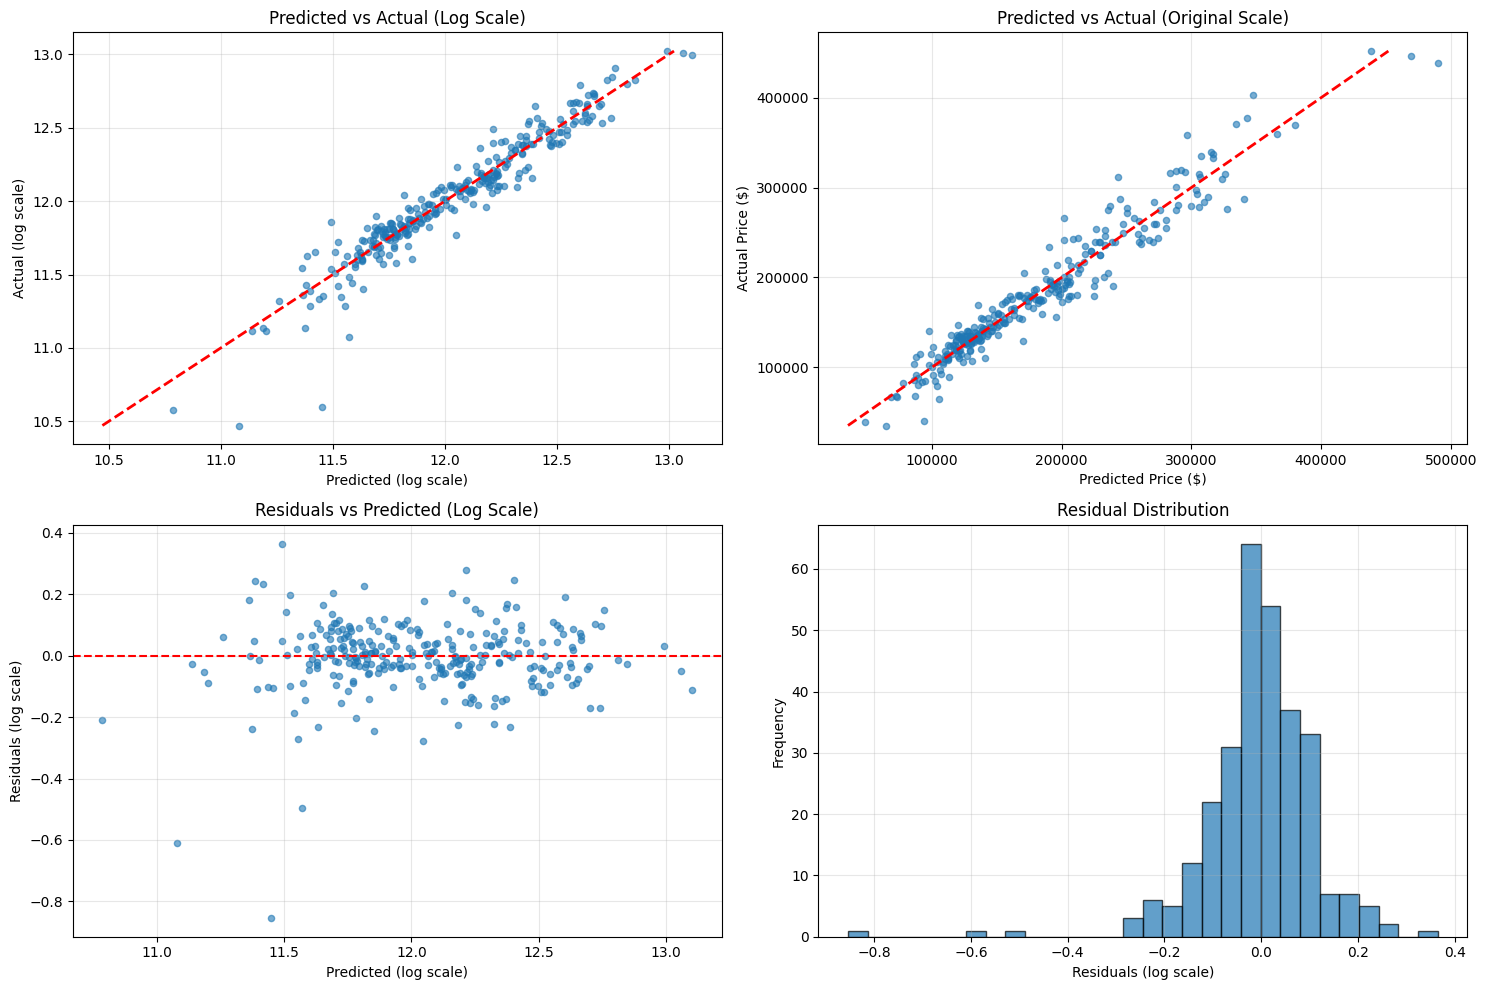

Residual Normality Test: statistic=154.3081, p-value=0.0000
Normal distribution: No
Mean residual: -0.005865
Residual std: 0.1176


In [22]:
print("\nResidual Analysis:")

residuals_log = y_val - val_predictions_log
residuals_original = y_val_original - val_predictions_original

# Create comprehensive residual plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Predicted vs Actual (log scale)
ax1.scatter(val_predictions_log, y_val, alpha=0.6, s=20)
ax1.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
ax1.set_xlabel('Predicted (log scale)')
ax1.set_ylabel('Actual (log scale)')
ax1.set_title('Predicted vs Actual (Log Scale)')
ax1.grid(True, alpha=0.3)

# Predicted vs Actual (original scale)
ax2.scatter(val_predictions_original, y_val_original, alpha=0.6, s=20)
ax2.plot([y_val_original.min(), y_val_original.max()], 
         [y_val_original.min(), y_val_original.max()], 'r--', lw=2)
ax2.set_xlabel('Predicted Price ($)')
ax2.set_ylabel('Actual Price ($)')
ax2.set_title('Predicted vs Actual (Original Scale)')
ax2.grid(True, alpha=0.3)

# Residuals vs Predicted (log scale)
ax3.scatter(val_predictions_log, residuals_log, alpha=0.6, s=20)
ax3.axhline(y=0, color='r', linestyle='--')
ax3.set_xlabel('Predicted (log scale)')
ax3.set_ylabel('Residuals (log scale)')
ax3.set_title('Residuals vs Predicted (Log Scale)')
ax3.grid(True, alpha=0.3)

# Residual distribution
ax4.hist(residuals_log, bins=30, alpha=0.7, edgecolor='black')
ax4.set_xlabel('Residuals (log scale)')
ax4.set_ylabel('Frequency')
ax4.set_title('Residual Distribution')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical analysis of residuals
from scipy.stats import normaltest

stat, p_value = normaltest(residuals_log)
print(f"Residual Normality Test: statistic={stat:.4f}, p-value={p_value:.4f}")
print(f"Normal distribution: {'Yes' if p_value > 0.05 else 'No'}")
print(f"Mean residual: {residuals_log.mean():.6f}")
print(f"Residual std: {residuals_log.std():.4f}")

In [23]:
print("\nFeature Importance Analysis:")

feature_importance = None

if hasattr(final_model, 'feature_importances_'):
    # Single model with feature importance
    feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': final_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
elif hasattr(final_model, 'coef_'):
    # Linear model with coefficients
    feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': np.abs(final_model.coef_)
    }).sort_values('Importance', ascending=False)
    
elif hasattr(final_model, 'fitted_models_'):
    # Ensemble model - average importance across component models
    importances_list = []
    for model in final_model.fitted_models_:
        if hasattr(model, 'feature_importances_'):
            importances_list.append(model.feature_importances_)
    
    if importances_list:
        avg_importance = np.mean(importances_list, axis=0)
        feature_importance = pd.DataFrame({
            'Feature': X_train.columns,
            'Importance': avg_importance
        }).sort_values('Importance', ascending=False)

if feature_importance is not None:
    print("Top 15 Most Important Features:")
    print("-" * 40)
    for idx, row in feature_importance.head(15).iterrows():
        print(f"{row['Feature']:<25} {row['Importance']:>10.4f}")
    
    # Plot feature importance
    plt.figure(figsize=(10, 8))
    top_features = feature_importance.head(20)
    plt.barh(range(len(top_features)), top_features['Importance'])
    plt.yticks(range(len(top_features)), top_features['Feature'])
    plt.xlabel('Importance Score')
    plt.title(f'Top 20 Feature Importances - {final_model_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
else:
    print("Feature importance not available for this model type")


Feature Importance Analysis:
Feature importance not available for this model type



Feature Importance Analysis:
Extracting importance from stacking ensemble base models...
Top 15 Most Important Features:
----------------------------------------
GrLivArea                   285.3255
TotalFlrSF                  279.7633
LotArea                     278.6916
BsmtFinSF                   259.1515
BsmtUnfSF                   251.3106
HouseAge                    221.6243
GarageAreaPerCar            206.5431
OverallCond                 203.9417
YearsSinceRemodel           192.1657
OverallQual                 177.4429
GarageAge                   148.2274
TotalBaths                  130.2455
OpenPorchSF                 119.3949
LotFrontage                 118.7291
WoodDeckSF                   97.1057


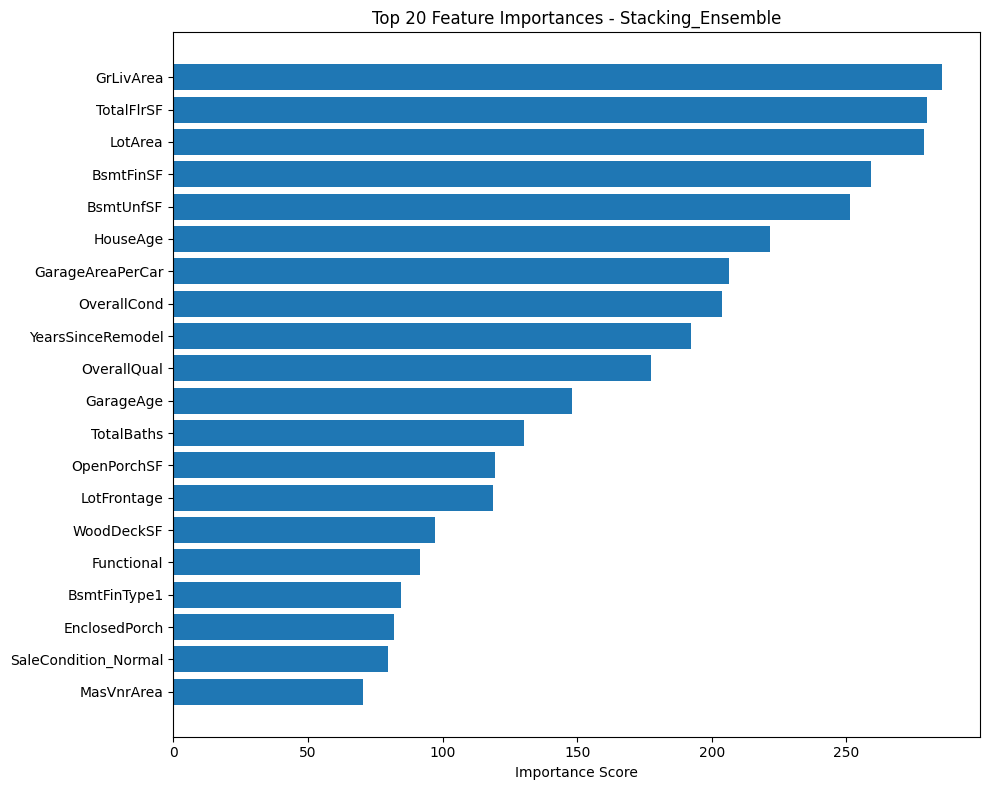

In [35]:
# Enhanced feature importance analysis
print("\nFeature Importance Analysis:")

feature_importance = None

# Handle different model types
if hasattr(final_model, 'feature_importances_'):
    # Single tree-based model
    feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': final_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
elif hasattr(final_model, 'coef_'):
    # Linear model
    feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': np.abs(final_model.coef_)
    }).sort_values('Importance', ascending=False)
    
elif hasattr(final_model, 'named_estimators_'):
    # Stacking ensemble
    print("Extracting importance from stacking ensemble base models...")
    importances_list = []
    for name, estimator in final_model.named_estimators_.items():
        if hasattr(estimator, 'feature_importances_'):
            importances_list.append(estimator.feature_importances_)
        elif hasattr(estimator, 'coef_'):
            importances_list.append(np.abs(estimator.coef_))
    
    if importances_list:
        avg_importance = np.mean(importances_list, axis=0)
        feature_importance = pd.DataFrame({
            'Feature': X_train.columns,
            'Importance': avg_importance
        }).sort_values('Importance', ascending=False)
        
elif hasattr(final_model, 'fitted_models_'):
    # Custom ensemble (SimpleEnsemble, WeightedEnsemble)
    print("Extracting importance from custom ensemble...")
    importances_list = []
    for model in final_model.fitted_models_:
        if hasattr(model, 'feature_importances_'):
            importances_list.append(model.feature_importances_)
        elif hasattr(model, 'coef_'):
            importances_list.append(np.abs(model.coef_))
    
    if importances_list:
        avg_importance = np.mean(importances_list, axis=0)
        feature_importance = pd.DataFrame({
            'Feature': X_train.columns,
            'Importance': avg_importance
        }).sort_values('Importance', ascending=False)

# Try alternative approaches if nothing worked
if feature_importance is None:
    print("Trying permutation importance as fallback...")
    try:
        from sklearn.inspection import permutation_importance
        perm_importance = permutation_importance(
            final_model, X_val, y_val, 
            n_repeats=5, random_state=42, n_jobs=-1
        )
        feature_importance = pd.DataFrame({
            'Feature': X_train.columns,
            'Importance': perm_importance.importances_mean
        }).sort_values('Importance', ascending=False)
        print("Using permutation importance (slower but works for any model)")
    except:
        print("Could not calculate feature importance for this model type")

# Display results
if feature_importance is not None:
    print("Top 15 Most Important Features:")
    print("-" * 40)
    for idx, row in feature_importance.head(15).iterrows():
        print(f"{row['Feature']:<25} {row['Importance']:>10.4f}")
    
    # Plot if you want
    plt.figure(figsize=(10, 8))
    top_features = feature_importance.head(20)
    plt.barh(range(len(top_features)), top_features['Importance'])
    plt.yticks(range(len(top_features)), top_features['Feature'])
    plt.xlabel('Importance Score')
    plt.title(f'Top 20 Feature Importances - {final_model_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
else:
    print("Feature importance not available for this model type")

In [36]:
def get_comprehensive_feature_importance(model, X_train, X_val, y_train, y_val, model_name="Model"):
    """
    Get feature importance using multiple methods
    """
    print(f"\nComprehensive Feature Importance Analysis for {model_name}")
    print("="*60)
    
    importance_results = {}
    
    # Method 1: Native importance
    if hasattr(model, 'feature_importances_'):
        importance_results['Native'] = model.feature_importances_
        print("✓ Native feature importance available")
    elif hasattr(model, 'coef_'):
        importance_results['Native'] = np.abs(model.coef_)
        print("✓ Linear coefficients available")
    
    # Method 2: Permutation importance
    try:
        from sklearn.inspection import permutation_importance
        perm_imp = permutation_importance(
            model, X_val, y_val, 
            n_repeats=5, 
            random_state=42,
            scoring='neg_mean_squared_error'
        )
        importance_results['Permutation'] = perm_imp.importances_mean
        print("✓ Permutation importance calculated")
    except Exception as e:
        print(f"✗ Permutation importance failed: {e}")
    
    # Method 3: SHAP (if available)
    try:
        import shap
        if hasattr(model, 'feature_importances_'):  # Tree models
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X_val.iloc[:100])
            importance_results['SHAP'] = np.abs(shap_values).mean(0)
            print("✓ SHAP importance calculated")
    except:
        print("✗ SHAP not available or failed")
    
    # Method 4: Correlation
    correlations = X_train.corrwith(y_train).abs()
    importance_results['Correlation'] = correlations.values
    print("✓ Correlation importance calculated")
    
    # Combine results
    feature_names = X_train.columns
    
    # Create comparison dataframe
    comparison_df = pd.DataFrame({'Feature': feature_names})
    
    for method, importance in importance_results.items():
        if len(importance) == len(feature_names):
            comparison_df[f'{method}_Importance'] = importance
            # Normalize to 0-1 scale for comparison
            comparison_df[f'{method}_Normalized'] = (importance - importance.min()) / (importance.max() - importance.min())
    
    # Calculate average ranking
    ranking_cols = [col for col in comparison_df.columns if 'Normalized' in col]
    if ranking_cols:
        comparison_df['Average_Importance'] = comparison_df[ranking_cols].mean(axis=1)
        comparison_df = comparison_df.sort_values('Average_Importance', ascending=False)
    
    return comparison_df

# Usage:
importance_df = get_comprehensive_feature_importance(
    final_model, X_train, X_val, y_train, y_val, final_model_name
)

# Display top features
print("\nTop 15 Features (Average across methods):")
print(importance_df[['Feature', 'Average_Importance']].head(15))


Comprehensive Feature Importance Analysis for Stacking_Ensemble
✓ Permutation importance calculated
✗ SHAP not available or failed
✓ Correlation importance calculated

Top 15 Features (Average across methods):
                  Feature  Average_Importance
21              GrLivArea            1.000000
7             OverallQual            0.628681
8             OverallCond            0.176620
47             TotalFlrSF            0.172892
2                 LotArea            0.153677
44               HouseAge            0.150951
46              BsmtFinSF            0.127984
48             TotalBaths            0.084217
45      YearsSinceRemodel            0.073156
189  SaleCondition_Normal            0.059283
24            KitchenQual            0.055008
26             Functional            0.037636
42              GarageAge            0.037589
1             LotFrontage            0.036987
17              BsmtUnfSF            0.036474


In [24]:
print("\n" + "="*60)
print("GENERATING FINAL TEST PREDICTIONS")
print("="*60)

print("WARNING: First and only time touching test data")

# Fit final model on complete training data
final_model.fit(X_train, y_log)

# Generate predictions on test set
test_predictions_log = final_model.predict(X_test)
test_predictions_original = np.exp(test_predictions_log)

print(f"Test predictions generated: {len(test_predictions_original)} samples")

# Prediction statistics
print(f"\nPrediction Statistics:")
print(f"  Range: ${test_predictions_original.min():,.0f} - ${test_predictions_original.max():,.0f}")
print(f"  Mean: ${test_predictions_original.mean():,.0f}")
print(f"  Median: ${np.median(test_predictions_original):,.0f}")
print(f"  Std: ${test_predictions_original.std():,.0f}")

# Sanity checks
print(f"\nSanity Checks:")
negative_count = (test_predictions_original < 0).sum()
low_count = (test_predictions_original < 10000).sum()
high_count = (test_predictions_original > 500000).sum()

print(f"  Negative predictions: {negative_count}")
print(f"  Very low predictions (<$10k): {low_count}")
print(f"  Very high predictions (>$500k): {high_count}")

# Compare with training distribution
train_mean = np.exp(y_log).mean()
test_mean = test_predictions_original.mean()
difference_pct = abs(test_mean - train_mean) / train_mean * 100

print(f"  Training mean: ${train_mean:,.0f}")
print(f"  Test prediction mean: ${test_mean:,.0f}")
print(f"  Difference: {difference_pct:.1f}%")

if difference_pct > 20:
    print("  WARNING: Large difference between train and test means")
else:
    print("  Distribution similarity: Good")


GENERATING FINAL TEST PREDICTIONS
Test predictions generated: 1459 samples

Prediction Statistics:
  Range: $47,690 - $701,555
  Mean: $178,964
  Median: $156,005
  Std: $79,131

Sanity Checks:
  Negative predictions: 0
  Very low predictions (<$10k): 0
  Very high predictions (>$500k): 7
  Training mean: $180,933
  Test prediction mean: $178,964
  Difference: 1.1%
  Distribution similarity: Good


In [25]:
# Create submission DataFrame
submission = pd.DataFrame({
    'Id': range(1461, 1461 + len(test_predictions_original)),
    'SalePrice': test_predictions_original
})

# Create submission filename
submission_filename = f'../submissions/submission_{final_model_name}5.csv'

# Save submission
submission.to_csv(submission_filename, index=False)

print(f"\nSubmission File Created:")
print(f"  Filename: {submission_filename}")
print(f"  Shape: {submission.shape}")

# Display submission preview
print(f"\nSubmission Preview:")
print(submission.head(10))
print("...")
print(submission.tail(5))

# Validate submission format
print(f"\nSubmission Validation:")
print(f"  IDs start at: {submission['Id'].min()}")
print(f"  IDs end at: {submission['Id'].max()}")
print(f"  ID count: {len(submission)}")
print(f"  Expected count: {len(X_test)}")
print(f"  Format valid: {len(submission) == len(X_test) and submission['Id'].min() == 1461}")


Submission File Created:
  Filename: ../submissions/submission_Stacking_Ensemble5.csv
  Shape: (1459, 2)

Submission Preview:
     Id      SalePrice
0  1461  115545.419014
1  1462  160534.686069
2  1463  181487.844246
3  1464  193782.818349
4  1465  192528.835989
5  1466  170491.926518
6  1467  171739.099485
7  1468  162240.787803
8  1469  185267.697244
9  1470  119970.695634
...
        Id      SalePrice
1454  2915   84378.882645
1455  2916   82832.341501
1456  2917  160069.446514
1457  2918  116028.023343
1458  2919  216451.375678

Submission Validation:
  IDs start at: 1461
  IDs end at: 2919
  ID count: 1459
  Expected count: 1459
  Format valid: True


In [26]:
print("\n" + "="*80)
print("CUSTOM MODEL SELECTION AND EXPERIMENTATION")
print("="*80)

# Available models for selection
available_models = {
    'Ridge': best_ridge,
    'Lasso': best_lasso, 
    'ElasticNet': best_elasticnet,
    'RandomForest': best_rf,
    'GradientBoosting': best_gb,
    'XGBoost': best_xgb,
    'CatBoost': best_catboost,
    'LightGBM': best_lightgbm
}

# Display available models with their performance
print("Available Optimized Models:")
print(f"{'Model':<15} {'CV RMSE':<12} {'Validation RMSE':<15}")
print("-"*45)
for model_name in available_models.keys():
    cv_rmse = optimized_results[f"{model_name}_Optimized"]['cv_rmse_mean']
    # Calculate validation RMSE for each model
    model = available_models[model_name]
    model.fit(X_train_split, y_train)
    val_pred = model.predict(X_val)
    val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
    print(f"{model_name:<15} {cv_rmse:<12.4f} {val_rmse:<15.4f}")


CUSTOM MODEL SELECTION AND EXPERIMENTATION
Available Optimized Models:
Model           CV RMSE      Validation RMSE
---------------------------------------------
Ridge           0.1218       0.1198         
Lasso           0.1175       0.1199         
ElasticNet      0.1175       0.1199         
RandomForest    0.1412       0.1450         
GradientBoosting 0.1227       0.1263         
XGBoost         0.1148       0.1257         
CatBoost        0.1143       0.1223         
LightGBM        0.1172       0.1272         


In [27]:
# ===== CONFIGURATION: SINGLE MODEL =====
# Choose your model here:
SELECTED_SINGLE_MODEL = 'CatBoost'  # Change this to: 'Ridge', 'Lasso', 'ElasticNet', 'RandomForest', 'GradientBoosting', 'XGBoost', 'CatBoost', 'LightGBM'

print(f"\n--- Testing Single Model: {SELECTED_SINGLE_MODEL} ---")

if SELECTED_SINGLE_MODEL in available_models:
    custom_single_model = available_models[SELECTED_SINGLE_MODEL]
    
    # Evaluate on validation set
    custom_single_model.fit(X_train_split, y_train)
    single_val_pred = custom_single_model.predict(X_val)
    single_val_rmse = np.sqrt(mean_squared_error(y_val, single_val_pred))
    single_val_original = np.exp(single_val_pred)
    y_val_original = np.exp(y_val)
    single_val_rmse_original = np.sqrt(mean_squared_error(y_val_original, single_val_original))
    single_r2 = r2_score(y_val_original, single_val_original)
    
    print(f"Single Model Results ({SELECTED_SINGLE_MODEL}):")
    print(f"  Validation RMSE (log): {single_val_rmse:.4f}")
    print(f"  Validation RMSE (original): ${single_val_rmse_original:,.0f}")
    print(f"  R² Score: {single_r2:.4f}")
    
    # Store for comparison
    custom_results = {
        f'Custom_Single_{SELECTED_SINGLE_MODEL}': {
            'model': custom_single_model,
            'val_rmse': single_val_rmse,
            'val_rmse_original': single_val_rmse_original,
            'r2': single_r2
        }
    }
else:
    print(f"Model '{SELECTED_SINGLE_MODEL}' not found!")


--- Testing Single Model: CatBoost ---
Single Model Results (CatBoost):
  Validation RMSE (log): 0.1223
  Validation RMSE (original): $19,628
  R² Score: 0.9303


In [28]:
# ===== CONFIGURATION: CUSTOM SIMPLE ENSEMBLE =====
# Choose your models here (list of model names):
SELECTED_ENSEMBLE_MODELS = ['CatBoost', 'XGBoost', 'LightGBM']  # Change this list as desired
ENSEMBLE_NAME = 'Custom_Simple_Ensemble'  # Name your ensemble

print(f"\n--- Testing Custom Simple Ensemble: {SELECTED_ENSEMBLE_MODELS} ---")

# Validate model selection
valid_models = []
for model_name in SELECTED_ENSEMBLE_MODELS:
    if model_name in available_models:
        valid_models.append(available_models[model_name])
        print(f"  ✓ Added {model_name}")
    else:
        print(f"  ✗ {model_name} not found - skipping")

if len(valid_models) >= 2:
    # Create custom simple ensemble
    custom_simple_ensemble = SimpleEnsemble(valid_models)
    
    # Evaluate custom ensemble
    custom_simple_ensemble.fit(X_train_split, y_train)
    custom_simple_pred = custom_simple_ensemble.predict(X_val)
    custom_simple_rmse = np.sqrt(mean_squared_error(y_val, custom_simple_pred))
    custom_simple_original = np.exp(custom_simple_pred)
    custom_simple_rmse_original = np.sqrt(mean_squared_error(y_val_original, custom_simple_original))
    custom_simple_r2 = r2_score(y_val_original, custom_simple_original)
    
    print(f"Custom Simple Ensemble Results:")
    print(f"  Models used: {len(valid_models)}")
    print(f"  Validation RMSE (log): {custom_simple_rmse:.4f}")
    print(f"  Validation RMSE (original): ${custom_simple_rmse_original:,.0f}")
    print(f"  R² Score: {custom_simple_r2:.4f}")
    
    # Store results
    custom_results[ENSEMBLE_NAME] = {
        'model': custom_simple_ensemble,
        'val_rmse': custom_simple_rmse,
        'val_rmse_original': custom_simple_rmse_original,
        'r2': custom_simple_r2,
        'model_count': len(valid_models)
    }
else:
    print("Need at least 2 valid models for ensemble!")


--- Testing Custom Simple Ensemble: ['CatBoost', 'XGBoost', 'LightGBM'] ---
  ✓ Added CatBoost
  ✓ Added XGBoost
  ✓ Added LightGBM
Custom Simple Ensemble Results:
  Models used: 3
  Validation RMSE (log): 0.1237
  Validation RMSE (original): $19,467
  R² Score: 0.9314


In [29]:
# ===== CONFIGURATION: SINGLE MODEL =====
# Choose your model here:
SELECTED_SINGLE_MODEL = 'CatBoost'  # Change this to: 'Ridge', 'Lasso', 'ElasticNet', 'RandomForest', 'GradientBoosting', 'XGBoost', 'CatBoost', 'LightGBM'

print(f"\n--- Testing Single Model: {SELECTED_SINGLE_MODEL} ---")

if SELECTED_SINGLE_MODEL in available_models:
    custom_single_model = available_models[SELECTED_SINGLE_MODEL]
    
    # Evaluate on validation set
    custom_single_model.fit(X_train_split, y_train)
    single_val_pred = custom_single_model.predict(X_val)
    single_val_rmse = np.sqrt(mean_squared_error(y_val, single_val_pred))
    single_val_original = np.exp(single_val_pred)
    y_val_original = np.exp(y_val)
    single_val_rmse_original = np.sqrt(mean_squared_error(y_val_original, single_val_original))
    single_r2 = r2_score(y_val_original, single_val_original)
    
    print(f"Single Model Results ({SELECTED_SINGLE_MODEL}):")
    print(f"  Validation RMSE (log): {single_val_rmse:.4f}")
    print(f"  Validation RMSE (original): ${single_val_rmse_original:,.0f}")
    print(f"  R² Score: {single_r2:.4f}")
    
    # Store for comparison
    custom_results = {
        f'Custom_Single_{SELECTED_SINGLE_MODEL}': {
            'model': custom_single_model,
            'val_rmse': single_val_rmse,
            'val_rmse_original': single_val_rmse_original,
            'r2': single_r2
        }
    }
    
    # Generate submission file for single model
    GENERATE_SINGLE_SUBMISSION = True  # Set to False to skip submission generation
    
    if GENERATE_SINGLE_SUBMISSION:
        print(f"\n--- Generating Submission for {SELECTED_SINGLE_MODEL} ---")
        
        # Train on full training data
        custom_single_model.fit(X_train, y_log)
        
        # Generate test predictions
        single_test_pred_log = custom_single_model.predict(X_test)
        single_test_pred_original = np.exp(single_test_pred_log)
        
        # Create submission
        single_submission = pd.DataFrame({
            'Id': range(1461, 1461 + len(single_test_pred_original)),
            'SalePrice': single_test_pred_original
        })
        
        # Save submission
        single_submission_filename = f'submission_single_{SELECTED_SINGLE_MODEL}.csv'
        single_submission.to_csv(single_submission_filename, index=False)
        
        print(f"  Submission saved: {single_submission_filename}")
        print(f"  Predictions: {len(single_test_pred_original)}")
        print(f"  Price range: ${single_test_pred_original.min():,.0f} - ${single_test_pred_original.max():,.0f}")
        print(f"  Mean prediction: ${single_test_pred_original.mean():,.0f}")
else:
    print(f"Model '{SELECTED_SINGLE_MODEL}' not found!")


--- Testing Single Model: CatBoost ---
Single Model Results (CatBoost):
  Validation RMSE (log): 0.1223
  Validation RMSE (original): $19,628
  R² Score: 0.9303

--- Generating Submission for CatBoost ---
  Submission saved: submission_single_CatBoost.csv
  Predictions: 1459
  Price range: $42,826 - $645,032
  Mean prediction: $178,693


In [30]:
# ===== CONFIGURATION: CUSTOM SIMPLE ENSEMBLE =====
# Choose your models here (list of model names):
SELECTED_ENSEMBLE_MODELS = ['CatBoost', 'XGBoost', 'LightGBM']  # Change this list as desired
ENSEMBLE_NAME = 'Custom_Simple_Ensemble'  # Name your ensemble

print(f"\n--- Testing Custom Simple Ensemble: {SELECTED_ENSEMBLE_MODELS} ---")

# Validate model selection
valid_models = []
for model_name in SELECTED_ENSEMBLE_MODELS:
    if model_name in available_models:
        valid_models.append(available_models[model_name])
        print(f"  ✓ Added {model_name}")
    else:
        print(f"  ✗ {model_name} not found - skipping")

if len(valid_models) >= 2:
    # Create custom simple ensemble
    custom_simple_ensemble = SimpleEnsemble(valid_models)
    
    # Evaluate custom ensemble
    custom_simple_ensemble.fit(X_train_split, y_train)
    custom_simple_pred = custom_simple_ensemble.predict(X_val)
    custom_simple_rmse = np.sqrt(mean_squared_error(y_val, custom_simple_pred))
    custom_simple_original = np.exp(custom_simple_pred)
    custom_simple_rmse_original = np.sqrt(mean_squared_error(y_val_original, custom_simple_original))
    custom_simple_r2 = r2_score(y_val_original, custom_simple_original)
    
    print(f"Custom Simple Ensemble Results:")
    print(f"  Models used: {len(valid_models)}")
    print(f"  Validation RMSE (log): {custom_simple_rmse:.4f}")
    print(f"  Validation RMSE (original): ${custom_simple_rmse_original:,.0f}")
    print(f"  R² Score: {custom_simple_r2:.4f}")
    
    # Store results
    custom_results[ENSEMBLE_NAME] = {
        'model': custom_simple_ensemble,
        'val_rmse': custom_simple_rmse,
        'val_rmse_original': custom_simple_rmse_original,
        'r2': custom_simple_r2,
        'model_count': len(valid_models)
    }
    
    # Generate submission file for simple ensemble
    GENERATE_SIMPLE_ENSEMBLE_SUBMISSION = True  # Set to False to skip submission generation
    
    if GENERATE_SIMPLE_ENSEMBLE_SUBMISSION:
        print(f"\n--- Generating Submission for Simple Ensemble ---")
        
        # Train on full training data
        custom_simple_ensemble.fit(X_train, y_log)
        
        # Generate test predictions
        simple_ensemble_test_pred_log = custom_simple_ensemble.predict(X_test)
        simple_ensemble_test_pred_original = np.exp(simple_ensemble_test_pred_log)
        
        # Create submission
        simple_ensemble_submission = pd.DataFrame({
            'Id': range(1461, 1461 + len(simple_ensemble_test_pred_original)),
            'SalePrice': simple_ensemble_test_pred_original
        })
        
        # Save submission
        model_names_str = "_".join(SELECTED_ENSEMBLE_MODELS)
        simple_ensemble_submission_filename = f'submission_simple_ensemble_{model_names_str}.csv'
        simple_ensemble_submission.to_csv(simple_ensemble_submission_filename, index=False)
        
        print(f"  Submission saved: {simple_ensemble_submission_filename}")
        print(f"  Models used: {SELECTED_ENSEMBLE_MODELS}")
        print(f"  Predictions: {len(simple_ensemble_test_pred_original)}")
        print(f"  Price range: ${simple_ensemble_test_pred_original.min():,.0f} - ${simple_ensemble_test_pred_original.max():,.0f}")
        print(f"  Mean prediction: ${simple_ensemble_test_pred_original.mean():,.0f}")
else:
    print("Need at least 2 valid models for ensemble!")


--- Testing Custom Simple Ensemble: ['CatBoost', 'XGBoost', 'LightGBM'] ---
  ✓ Added CatBoost
  ✓ Added XGBoost
  ✓ Added LightGBM
Custom Simple Ensemble Results:
  Models used: 3
  Validation RMSE (log): 0.1237
  Validation RMSE (original): $19,467
  R² Score: 0.9314

--- Generating Submission for Simple Ensemble ---
  Submission saved: submission_simple_ensemble_CatBoost_XGBoost_LightGBM.csv
  Models used: ['CatBoost', 'XGBoost', 'LightGBM']
  Predictions: 1459
  Price range: $46,169 - $703,281
  Mean prediction: $178,638


In [ ]:
# ===== CONFIGURATION: CUSTOM STACKING ENSEMBLE =====
# Choose your base models and meta-learner:
STACKING_BASE_MODELS = ['CatBoost', 'XGBoost', 'Lasso', 'ElasticNet']  # Base model names
META_LEARNER_TYPE = 'Ridge'  # Options: 'Ridge', 'Lasso', 'ElasticNet', 'RandomForest'
STACKING_CV_FOLDS = 3  # CV folds for stacking

print(f"\n--- Testing Custom Stacking Ensemble ---")

# Validate base models
valid_stacking_models = []
stacking_estimators = []

for i, model_name in enumerate(STACKING_BASE_MODELS):
    if model_name in available_models:
        valid_stacking_models.append(available_models[model_name])
        stacking_estimators.append((f"model_{i}_{model_name}", available_models[model_name]))
        print(f"  ✓ Added base model {model_name}")
    else:
        print(f"  ✗ {model_name} not found - skipping")

if len(valid_stacking_models) >= 2:
    # Choose meta-learner
    meta_learners = {
        'Ridge': Ridge(alpha=1.0, random_state=RANDOM_STATE),
        'Lasso': Lasso(alpha=0.1, random_state=RANDOM_STATE),
        'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=RANDOM_STATE),
        'RandomForest': RandomForestRegressor(n_estimators=50, random_state=RANDOM_STATE, n_jobs=-1)
    }
    
    if META_LEARNER_TYPE in meta_learners:
        meta_learner = meta_learners[META_LEARNER_TYPE]
        print(f"  Using {META_LEARNER_TYPE} as meta-learner")
    else:
        meta_learner = Ridge(alpha=1.0, random_state=RANDOM_STATE)
        print(f"  {META_LEARNER_TYPE} not found, using Ridge as meta-learner")
    
    # Create custom stacking ensemble
    custom_stacking_ensemble = StackingRegressor(
        estimators=stacking_estimators,
        final_estimator=meta_learner,
        cv=STACKING_CV_FOLDS,
        n_jobs=-1
    )
    
    # Evaluate custom stacking ensemble
    custom_stacking_ensemble.fit(X_train_split, y_train)
    custom_stacking_pred = custom_stacking_ensemble.predict(X_val)
    custom_stacking_rmse = np.sqrt(mean_squared_error(y_val, custom_stacking_pred))
    custom_stacking_original = np.exp(custom_stacking_pred)
    custom_stacking_rmse_original = np.sqrt(mean_squared_error(y_val_original, custom_stacking_original))
    custom_stacking_r2 = r2_score(y_val_original, custom_stacking_original)
    
    print(f"Custom Stacking Ensemble Results:")
    print(f"  Base models: {len(valid_stacking_models)}")
    print(f"  Meta-learner: {META_LEARNER_TYPE}")
    print(f"  CV folds: {STACKING_CV_FOLDS}")
    print(f"  Validation RMSE (log): {custom_stacking_rmse:.4f}")
    print(f"  Validation RMSE (original): ${custom_stacking_rmse_original:,.0f}")
    print(f"  R² Score: {custom_stacking_r2:.4f}")
    
    # Store results
    custom_results['Custom_Stacking_Ensemble'] = {
        'model': custom_stacking_ensemble,
        'val_rmse': custom_stacking_rmse,
        'val_rmse_original': custom_stacking_rmse_original,
        'r2': custom_stacking_r2,
        'meta_learner': META_LEARNER_TYPE,
        'base_model_count': len(valid_stacking_models)
    }
    
    # Generate submission file for stacking ensemble
    GENERATE_STACKING_ENSEMBLE_SUBMISSION = True  # Set to False to skip submission generation
    
    if GENERATE_STACKING_ENSEMBLE_SUBMISSION:
        print(f"\n--- Generating Submission for Stacking Ensemble ---")
        
        # Train on full training data
        custom_stacking_ensemble.fit(X_train, y_log)
        
        # Generate test predictions
        stacking_ensemble_test_pred_log = custom_stacking_ensemble.predict(X_test)
        stacking_ensemble_test_pred_original = np.exp(stacking_ensemble_test_pred_log)
        
        # Create submission
        stacking_ensemble_submission = pd.DataFrame({
            'Id': range(1461, 1461 + len(stacking_ensemble_test_pred_original)),
            'SalePrice': stacking_ensemble_test_pred_original
        })
        
        # Save submission
        base_models_str = "_".join(STACKING_BASE_MODELS)
        stacking_ensemble_submission_filename = f'submission_stacking_ensemble_{base_models_str}_{META_LEARNER_TYPE}.csv'
        stacking_ensemble_submission.to_csv(stacking_ensemble_submission_filename, index=False)
        
        print(f"  Submission saved: {stacking_ensemble_submission_filename}")
        print(f"  Base models: {STACKING_BASE_MODELS}")
        print(f"  Meta-learner: {META_LEARNER_TYPE}")
        print(f"  CV folds: {STACKING_CV_FOLDS}")
        print(f"  Predictions: {len(stacking_ensemble_test_pred_original)}")
        print(f"  Price range: ${stacking_ensemble_test_pred_original.min():,.0f} - ${stacking_ensemble_test_pred_original.max():,.0f}")
        print(f"  Mean prediction: ${stacking_ensemble_test_pred_original.mean():,.0f}")
else:
    print("Need at least 2 valid models for stacking ensemble!")


--- Testing Custom Stacking Ensemble ---
  ✓ Added base model CatBoost
  ✓ Added base model XGBoost
  ✓ Added base model Lasso
  ✓ Added base model ElasticNet
  Using Ridge as meta-learner
Custom Stacking Ensemble Results:
  Base models: 4
  Meta-learner: Ridge
  CV folds: 5
  Validation RMSE (log): 0.1172
  Validation RMSE (original): $18,686
  R² Score: 0.9368

--- Generating Submission for Stacking Ensemble ---
  Submission saved: submission_stacking_ensemble_CatBoost_XGBoost_Lasso_ElasticNet_Ridge.csv
  Base models: ['CatBoost', 'XGBoost', 'Lasso', 'ElasticNet']
  Meta-learner: Ridge
  CV folds: 5
  Predictions: 1459
  Price range: $47,644 - $700,471
  Mean prediction: $178,917
